In [21]:
include("../code/ldgm.jl")
include("../code/ldpc_graph.jl")
include("../code/bp.jl")

plot_rdb (generic function with 1 method)

## BP

In [2]:
lambda = zeros(7); lambda[7] = 1
rho = [0.01, 0.266598, 0.25537, 0.076598, 0, 0, 0, 0, 0.39233]
Lambda,Rho = edges2nodes(lambda, rho)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.03434489872357184, 0.4578140654953402, 0.29235522623461796, 0.06576876381070389, 0.0, 0.0, 0.0, 0.0, 0.149717045735766])

In [3]:
n, k, nedges, P, Λ = valid_degrees(Rho, Lambda)

(1470, 726, 5082, [0.03333333333333333, 0.45714285714285713, 0.2904761904761905, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.1523809523809524], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

In [4]:
check_consistency_polynomials_ldgm(n, k, nedges, Λ, P)

In [6]:
bp = ldgm(n, k, nedges, Λ, P);

In [119]:
# find neighbors of degree 1 factor
w = vec(sum(bp.G,dims=2))
f = findfirst(isequal(1),w)
v = findfirst(bp.G[f,:])

198

In [120]:
ξ = 0.02
@show β = (1-ξ)/(1+ξ)
@show H = atanh(β)
s = rand((-1,1), n)   # source
efield = [(exp(ss*H),exp(-ss*H)) for ss in s]
bp.efield .= efield;

β = (1 - ξ) / (1 + ξ) = 0.9607843137254901
H = atanh(β) = 1.9560115027140719


In [121]:
σ = 1e-3
for i in eachindex(bp.h)
    bp.h[i] = bp.h[i].+ σ.*(randn(),randn())
    bp.u[i] = bp.u[i].+ σ.*(randn(),randn())
end
for j in eachindex(bp.belief)
   bp.belief[j] = bp.belief[j] .+ σ.*(randn(),randn()) 
end

In [122]:
ε, niters = iteration!(bp, maxiter=10^4, damp=0.5, rein=1e-3)

(1.955412538223733e-6, 10000)

In [124]:
ovl,dist = performance(bp, s)

(0.32789115646258504, 0.3360544217687075)

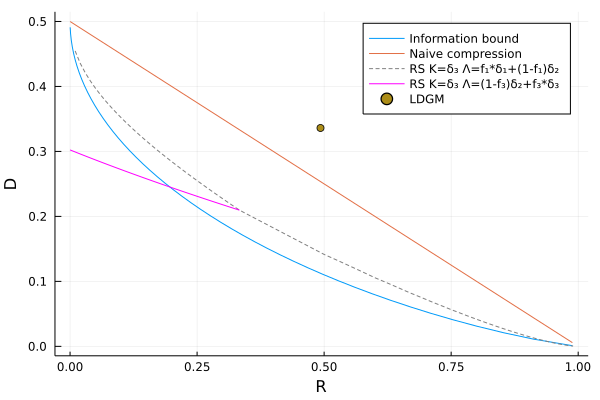

In [125]:
pl = plot_rdb()
scatter!([R], [dist], label="LDGM")

## BP, varying rate
Factors of degree 2, variables of degree 1 and 2

In [24]:
rr = 0.1:0.1:0.9
RR = zero(rr)
DD = zero(rr)
DD_sd = zero(rr)
navg = 5
n = 7200
H = 15
for (i,r) in enumerate(rr)
    println("$i of ", length(rr), " finished")
    m = round(Int, n*(1-r))
    nedges, Λ, K = generate_polyn(n,m,degree_type=:nodes)
    D = zeros(navg)
    for j in 1:navg
        G = ldpc_matrix(n, m, nedges, Λ, K)
        G = G[:,1:end-1];
        RR[i] = size(G,2)/n
        s = rand((-1,1), n)   # source
        efield = [(exp(ss*H),exp(-ss*H)) for ss in s]
        bp = LDGM(G, efield);
        ε, niters = iteration!(bp, maxiter=10^4, damp=0.5)
        ovl, D[j] = performance(bp, s)
    end
    DD[i] = mean(D)
    DD_sd[i] = std(D)/sqrt(navg)
end

1 of 9 finished
2 of 9 finished
3 of 9 finished
4 of 9 finished
5 of 9 finished
6 of 9 finished
7 of 9 finished
8 of 9 finished
9 of 9 finished


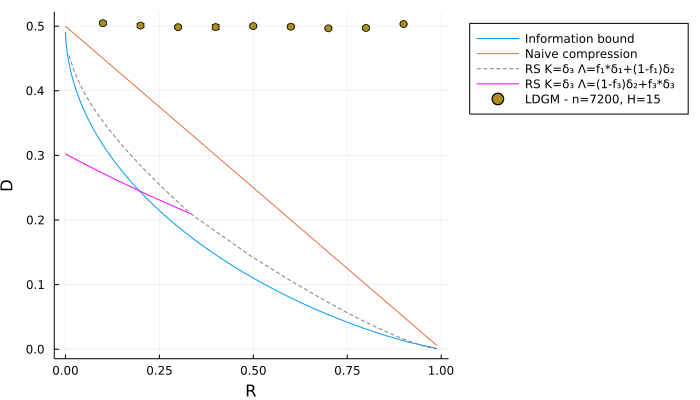

In [28]:
plot_rdb()
scatter!(RR,DD, label="LDGM - n=$n, H=$H", yerr=DD_sd, legend=:outertopright, size=(700,400))

## Max-Sum

Factors of degree 2, variables of degree 1 and 2

In [33]:
function rand_msg!(v, f=rand())
   for i in eachindex(v)
        v[i] = (f(),f())
    end
    v
end   
function rand_msg(N::Int, f=rand())
     v = zeros(N)
     rand_msg!(v, f)
end

rand_msg (generic function with 2 methods)

In [103]:
n = 7200*2
@show n
r = 0.7
m = round(Int, n*(1-r))
nedges, Λ, K = generate_polyn(n,m,degree_type=:nodes)
b = 150*2
G = ldpc_matrix(n, m, nedges, Λ, K)
# remove b factors
G = G[:,1:end-b];

n = 14400


In [104]:
k = size(G,2)
noise = 1e-4
R = k/n
H = 1
s = rand((-1,1), n)   # source
efield = [(ss*H+noise*randn(),-ss*H+noise*randn()) for ss in s]
ms = LDGM(G, s, efield);

In [105]:
rand_msg!(ms.u, ()->noise*randn())
rand_msg!(ms.h, ()->noise*randn())
rand_msg!(ms.belief, ()->noise*randn());

In [106]:
maxiter = 500
dist = zeros(maxiter)
ε, niters = iteration!(ms, maxiter=maxiter, damp=0.5, dist=dist, rein=1e-3,
    update_v! = update_var_ms!, update_f! = update_factor_ms!)

(3.446173394343451, 500)

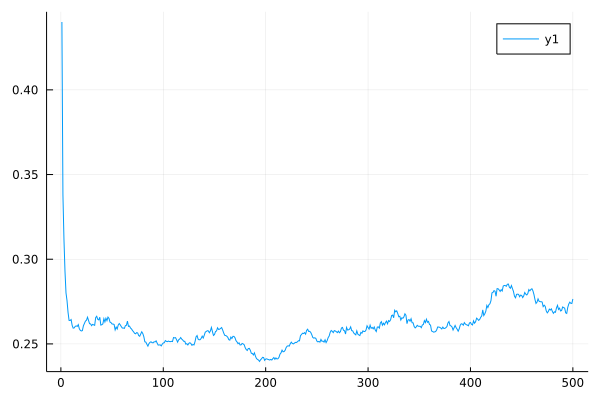

In [107]:
plot(dist)

In [108]:
ovl,d = performance(ms)

(0.4469444444444445, 0.27652777777777776)

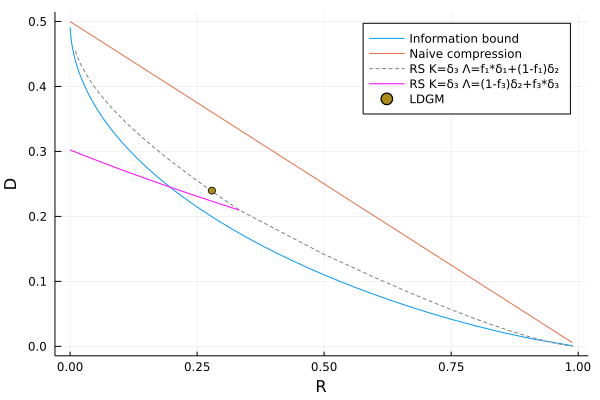

In [109]:
pl = plot_rdb()
scatter!([R], [minimum(dist)], label="LDGM")